In [ ]:
# Step 1: Install Kaggle
!pip install kaggle

# Step 2: Upload Kaggle API Key (kaggle.json)
from google.colab import files
files.upload()  # Choose the kaggle.json file from your local system

# Step 3: Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download the Dataset
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

# Step 5: Unzip the Dataset
import zipfile
import os

# Create a directory for the dataset
dataset_dir = "deepfake_dataset"
os.makedirs(dataset_dir, exist_ok=True)

# Unzip the downloaded file
with zipfile.ZipFile("deepfake-and-real-images.zip", "r") as zip_ref:
    zip_ref.extractall(dataset_dir)

print(f"Dataset extracted to: {dataset_dir}")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
 99% 1.67G/1.68G [00:22<00:00, 213MB/s]
100% 1.68G/1.68G [00:22<00:00, 81.3MB/s]
Dataset extracted to: deepfake_dataset


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Paths to dataset folders
dataset_dir = "deepfake_dataset/Dataset"
train_dir = os.path.join(dataset_dir, "Train")
val_dir = os.path.join(dataset_dir, "Validation")
test_dir = os.path.join(dataset_dir, "Test")

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Load datasets
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
val_data = datasets.ImageFolder(root=val_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")


Train samples: 140002
Validation samples: 39428
Test samples: 10905


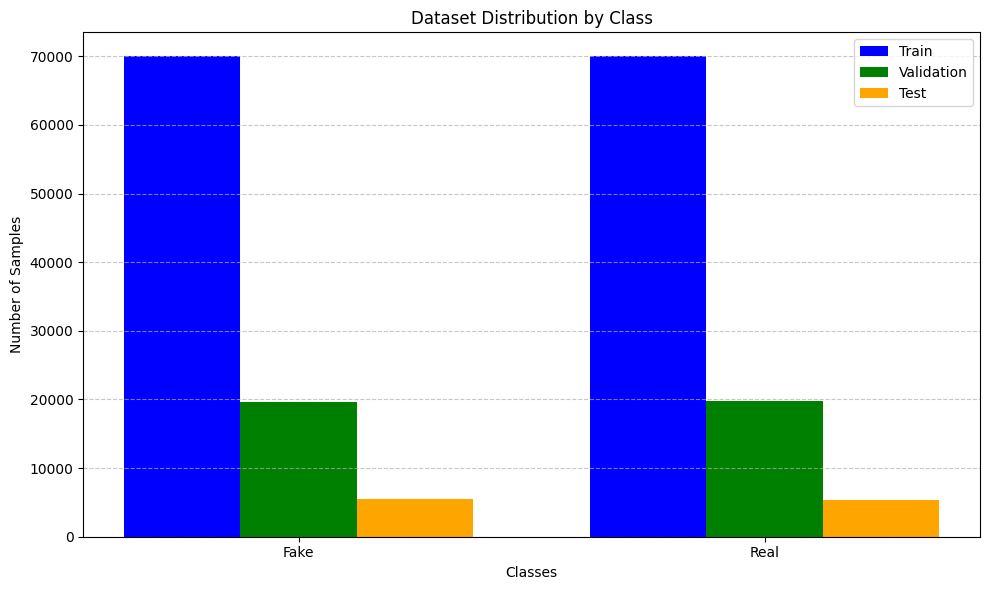

In [ ]:
import matplotlib.pyplot as plt

# Function to count samples per class in a dataset
def count_samples_per_class(dataset, class_names):
    counts = [0] * len(class_names)
    for _, label in dataset:
        counts[label] += 1
    return counts

# Count samples in each dataset
train_counts = count_samples_per_class(train_data, train_data.classes)
val_counts = count_samples_per_class(val_data, val_data.classes)
test_counts = count_samples_per_class(test_data, test_data.classes)

# Plot the distribution
x = range(len(train_data.classes))  # Class indices
width = 0.25  # Width of each bar

plt.figure(figsize=(10, 6))

# Plot bars for each dataset
plt.bar([i - width for i in x], train_counts, width=width, label='Train', color='blue')
plt.bar(x, val_counts, width=width, label='Validation', color='green')
plt.bar([i + width for i in x], test_counts, width=width, label='Test', color='orange')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Dataset Distribution by Class')
plt.xticks(x, train_data.classes)  # Use class names as x-axis labels
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


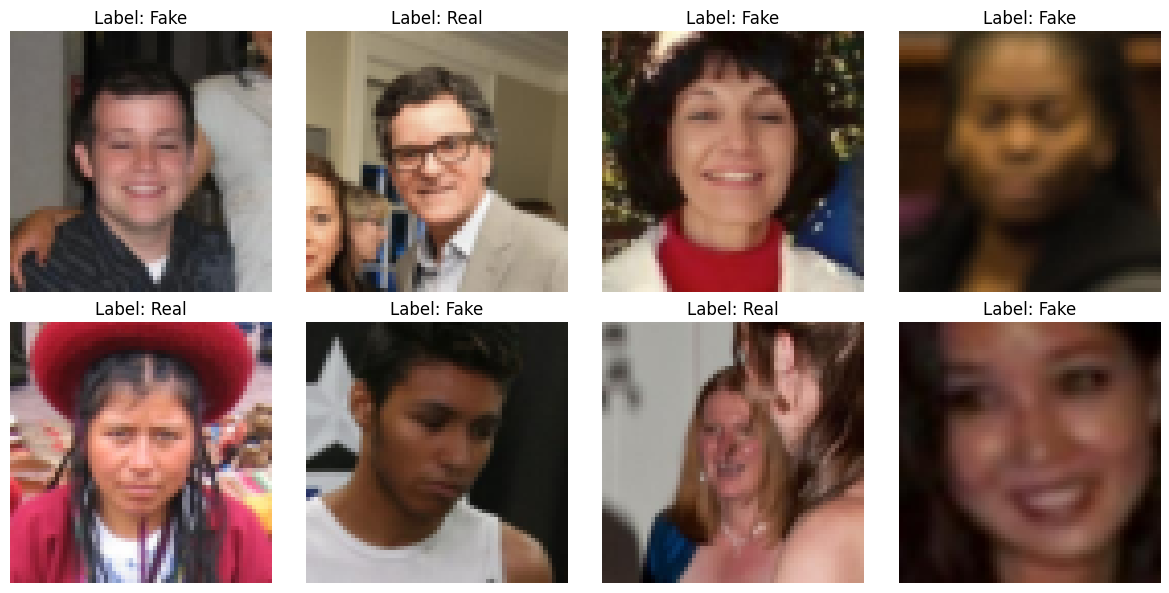

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display a batch of images with labels
def visualize_batch(data_loader, class_names):
    # Get one batch of images and labels
    images, labels = next(iter(data_loader))

    # Convert images to numpy format for plotting
    images = images.numpy()

    # Create a grid to display multiple images
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    for img, lbl, ax in zip(images[:8], labels[:8], axes):  # Display 8 images
        img = np.transpose(img, (1, 2, 0))  # Convert from CxHxW to HxWxC
        ax.imshow(img)
        ax.set_title(f"Label: {class_names[lbl]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Class names (automatically fetched from the dataset)
class_names = train_data.classes  # ['Fake', 'Real']

# Visualize a batch from the training dataset
visualize_batch(train_loader, class_names)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # input channels, output channels, kernel size
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)  # Adjust based on the output from conv layers
        self.fc2 = nn.Linear(512, 2)  # Output layer for 2 classes (real/fake)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 16 * 16)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to dataset folders
dataset_dir = "deepfake_dataset/Dataset"
train_dir = os.path.join(dataset_dir, "Train")
val_dir = os.path.join(dataset_dir, "Validation")
test_dir = os.path.join(dataset_dir, "Test")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Lower resolution for efficiency
    transforms.ToTensor(),
])

# Load datasets
train_loader = DataLoader(datasets.ImageFolder(train_dir, transform), batch_size=16, shuffle=True)
val_loader = DataLoader(datasets.ImageFolder(val_dir, transform), batch_size=16, shuffle=False)
test_loader = DataLoader(datasets.ImageFolder(test_dir, transform), batch_size=16, shuffle=False)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)   # Conv1
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)  # Conv2
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1) # Conv3
        self.fc1 = nn.Linear(32 * 8 * 8, 64)         # Fully connected 1
        self.fc2 = nn.Linear(64, 2)                 # Fully connected 2 (Binary classification)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 32 * 8 * 8)  # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Initialize model, loss, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss/len(train_loader):.4f}")
        evaluate_model(model, val_loader, criterion, phase='Validation')

# Evaluation function
def evaluate_model(model, loader, criterion, phase='Test'):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"{phase} Loss: {loss/len(loader):.4f}, Accuracy: {accuracy:.2f}%")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

# Test the model
evaluate_model(model, test_loader, criterion, phase='Test')


Epoch 1/5, Training Loss: 0.4301
Validation Loss: 0.4068, Accuracy: 81.61%
Epoch 2/5, Training Loss: 0.3137
Validation Loss: 0.3653, Accuracy: 83.84%
Epoch 3/5, Training Loss: 0.2720
Validation Loss: 0.3417, Accuracy: 84.88%
Epoch 4/5, Training Loss: 0.2472
Validation Loss: 0.3088, Accuracy: 86.91%
Epoch 5/5, Training Loss: 0.2259
Validation Loss: 0.2949, Accuracy: 87.16%
Test Loss: 0.3242, Accuracy: 86.19%


In [ ]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Test the model
test(model, test_loader)


Test Accuracy: 86.19%


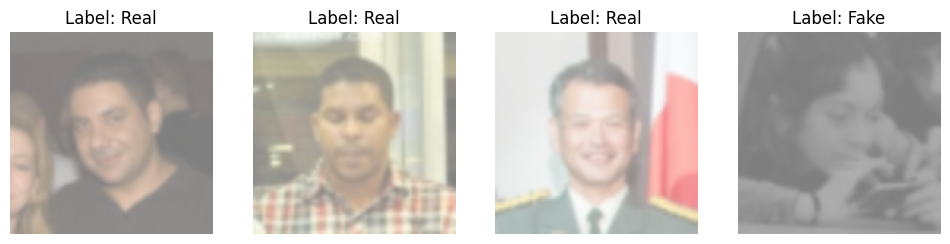

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, utils

# Helper function to display a batch of images
def show_images(images, labels, label_map, display_size=(128, 128)):
    batch_size = len(images)
    # Transform for resizing the images to a larger display size
    resize_transform = transforms.Resize(display_size)

    # Set up the figure size
    plt.figure(figsize=(batch_size * 3, 3))

    for i in range(batch_size):
        # Resize each image for display purposes only
        img = resize_transform(images[i])
        img = img * 0.5 + 0.5  # Undo normalization if normalized
        npimg = img.numpy()

        plt.subplot(1, batch_size, i + 1)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(f"Label: {label_map[labels[i].item()]}")
        plt.axis('off')

    plt.show()

# Define label map
label_map = {0: "Fake", 1: "Real"}

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display a batch with resized images for clarity
show_images(images[:4], labels[:4], label_map, display_size=(128, 128))


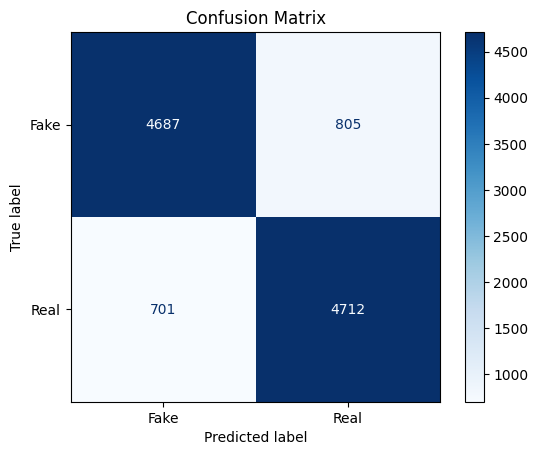

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to compute predictions and plot confusion matrix
def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    # Collect all predictions and true labels
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Class names (assuming binary classification: Real and Fake)
class_names = train_data.classes  # Automatically fetches class names from the dataset

# Call the function for the test set
plot_confusion_matrix(model, test_loader, class_names)
